# Training based on Labelled Dataset

# **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# !Pip Statements

In [3]:
!pip install tensorflow==2.15.0

!pip install emoji
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.4 MB/s eta 0:00:00


# Import Statements

In [4]:
import pandas as pd
import re
import nltk
import numpy as np
import os
import io
import csv
import collections
import string
import emoji
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Preprocessing

The preprocessing steps performed:

1. **Replacing Emotions with Descriptions**: Converts emoticons and certain textual emoticons into descriptive words like 'good', 'smile', 'sad', etc.
2. **General Replacements**: Replaces specific textual expressions like contractions ('you're' to 'you are', 'don't' to 'do not', etc.) and slang terms.
3. **Removing Twitter Handles and Hashtags**: Eliminates Twitter handles (e.g., @username) and hashtag symbols (#) from the tweet.
4. **Replacing Special Characters and Symbols**: Handles various symbols, punctuation marks, and special characters by either removing or replacing them.
5. **Replacing Emojis with Text Descriptions**: Converts emojis into text descriptions using the emoji library.
6. **Removing URLs**: Eliminates URLs (e.g., http://example.com) from the tweet.
7. **Removing Numerical Characters**: Removes numerical characters (digits) from the tweet.
8. **Tokenization and Lemmatization**: Tokenizes the tweet into individual words or tokens and then lemmatizes them to their base form.
9. **Stopwords Removal**: Removes common English stopwords from the tweet tokens.
10. **Parts of Speech Tagging**: Performs parts of speech tagging on the tokenized tweet to identify grammatical elements.
11. **Counting Punctuation Marks**: Counts the number of punctuation marks in each word.
12. **Counting Repeated Letters**: Identifies and counts repeated letters in each word to capture repetition patterns.
13. **Counting Capital Letters**: Counts the number of capital letters in each word to capture emphasis or proper nouns.
14. **Sentiment Scoring**: Assigns sentiment scores to words based on SentiWordNet, a lexical resource for sentiment analysis.
15. **Identifying Positive and Negative Words**: Determines whether words in the tweet have a positive or negative sentiment based on their sentiment scores.
16. **Exporting Processed Tweets to CSV**: Saves the processed tweets along with additional features (like repetition count, capital count, sentiment scores) to a CSV file.

In [5]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/Train.csv", encoding="latin-1")
print(df)

       label                                               text
0          1  It feels like just a few days ago it was the l...
1          1  I love my mom . No matter what we go through ,...
2          1      Bump that music ... #imtryingtosleep #sarcasm
3          0  Mexican and black jokes are pretty much the sa...
4          0                        How to find work you love :
...      ...                                                ...
51184      1  RT My EX had one very annoying habit . Breathi...
51185      1  Some days you're the Titanic , some days you'r...
51186      0  Congrats on the release of 25 @Adele , let's h...
51187      1         doing my favorite thing .. crying #sarcasm
51188      1  @TheSupremEC0URT roommate of the week really l...

[51189 rows x 2 columns]


In [6]:
#Replacing emotions with description
emo_repl = {
    # Good emotions
    "&lt;3" : " good ",
    ":d" : " good ",
    ":dd" : " good ",
    ":p" : " good ",
    "8)" : " good ",
    ":-)" : " good ",
    ":)" : " good ",
    ";)" : " good ",
    "(-:" : " good ",
    "(:" : " good ",

    "yay!" : " good ",
    "yay" : " good ",
    "yaay" : " good ",
    "yaaay" : " good ",
    "yaaaay" : " good ",
    "yaaaaay" : " good ",
    # Bad emotions
    ":/" : " bad ",
    ":&gt;" : " sad ",
    ":')" : " sad ",
    ":-(" : " bad ",
    ":(" : " bad ",
    ":s" : " bad ",
    ":-s" : " bad "
}

emo_repl2 = {
    # Good emotions
    "&lt;3" : " heart ",
    ":d" : " smile ",
    ":p" : " smile ",
    ":dd" : " smile ",
    "8)" : " smile ",
    ":-)" : " smile ",
    ":)" : " smile ",
    ";)" : " smile ",
    "(-:" : " smile ",
    "(:" : " smile ",

    # Bad emotions
    ":/" : " worry ",
    ":&gt;" : " angry ",
    ":')" : " sad ",
    ":-(" : " sad ",
    ":(" : " sad ",
    ":s" : " sad ",
    ":-s" : " sad "
}

# General replacements
re_repl = {
    r"\br\b" : "are",
    r"\bu\b" : "you",
    r"\bhaha\b" : "ha",
    r"\bshe's\b" : "she is",
    r"\bhe's\b" : "he is",
    r"\bi'm\b" : "i am",
    r"\blet's\b" : "let us",
    r"\bthat's\b" : "that is",
    r"\bwhat's\b" : "what is",
    r"\bwhere's\b" : "where is",
    r"\b've\b" : "have",
    r"\byou're\b" : "you are",
    r"\b'd\b" : "would",
    r"\bit's\b" : "it is",
    r"\bhahaha\b" : "ha",
    r"\bdon't\b" : "do not",
    r"\bdoesn't\b" : "does not",
    r"\bdidn't\b" : "did not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhadn't\b" : "had not",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\bcan't\b" : "can not",
    r"\bcannot\b" : "can not"
}

emo_repl_order = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
emo_repl_order2 = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl2.keys()]))]

def replace_emo(sentence):
    if isinstance(sentence, str):
        sentence2 = sentence
        for k in emo_repl_order:
            sentence2 = sentence2.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            sentence2 = re.sub(r, repl, sentence2)
        return sentence2
    else:
        return sentence

def replace_reg(sentence):
    if isinstance(sentence, str):
        sentence2 = sentence
        for k in emo_repl_order2:
            sentence2 = sentence2.replace(k, emo_repl2[k])
        for r, repl in re_repl.items():
            sentence2 = re.sub(r, repl, sentence2)
        return sentence2
    else:
        return sentence

df['text'] = df['text'].apply(replace_emo)
df['text'] = df['text'].apply(replace_reg)

df.to_csv('/content/drive/MyDrive/Labelled_Dataset/LSTM/Dataset1.csv', index=False)
print('Processed tweets exported to dataset1.csv')

Processed tweets exported to dataset1.csv


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

class TweetAnalyzer:
    def __init__(self):
        self.sent_scores = self.load_senti_word_net()

    def load_senti_word_net(self):
        sent_scores = collections.defaultdict(list)
        with io.open("/content/drive/MyDrive/SentiWordNet_3.0.0_20130122.txt") as fname:
            file_content = csv.reader(fname, delimiter='\t', quotechar='"')

            for line in file_content:
                if len(line) != 6:
                    continue

                if line[0].startswith('#'):
                    continue
                pos, ID, PosScore, NegScore, synsetTerms, gloss = line
                for terms in synsetTerms.split(" "):
                    term = terms.split("#")[0]
                    term = term.replace("-", "").replace("_", "")
                    key = "%s/%s" % (pos, term.split("#")[0])
                    try:
                        sent_scores[key].append((float(PosScore), float(NegScore)))
                    except:
                        sent_scores[key].append((0, 0))

        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)

        return sent_scores

    def preprocess_tweet(self, text):
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#', '', text)
        text = re.sub(r'sarcasm|sarcastic|sarcastically', '', text)
        text = re.sub(r'&', 'and', text)
        text = re.sub(r'http\S+|www\S+|pic.twitter\S+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s&?!\'-]|(?<=\s)-|-(?=\s)|(?<=\s)–|–(?=\s)|(?<=\s)—|—(?=\s)', '', text)
        text = emoji.demojize(text)
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
        text = ' '.join(tokens)
        pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
        punctuations = [sum(1 for char in word if char in string.punctuation) for word, _ in pos_tags]
        repetition = [sum(1 for i in range(len(word)-1) if word[i] == word[i+1]) for word, _ in pos_tags]
        capital = [sum(1 for char in word if char.isupper()) for word, _ in pos_tags]
        positive_words = []
        negative_words = []
        sentiment_scores = []

        for word, pos in pos_tags:
            pos_score, neg_score = self.score_word(word)
            sentiment_scores.append((word, pos_score, neg_score))
            if pos_score > neg_score:
                positive_words.append(word)
            elif pos_score < neg_score:
                negative_words.append(word)

        return {
            'text': text,
            'capital': capital,
            'pos_tags': pos_tags,
            'positive_words': positive_words,
            'negative_words': negative_words,
            'sentiment_scores': sentiment_scores,
            'repetition': repetition,
            'punctuation_count': punctuations,
        }

    def score_word(self, word):
        pos = nltk.pos_tag([word])[0][1]
        return self.score(word, pos)

    def score(self, word, pos):
        if pos[0:2] == 'NN':
            pos_type = 'n'
        elif pos[0:2] == 'JJ':
            pos_type = 'a'
        elif pos[0:2] =='VB':
            pos_type='v'
        elif pos[0:2] =='RB':
            pos_type = 'r'
        else:
            pos_type =  0

        if pos_type != 0 :
            loc = pos_type+'/'+word
            score = self.sent_scores[loc]
            if len(score)>1:
                return score
            else:
                return np.array([0.0,0.0])
        else:
            return np.array([0.0,0.0])

    def score_sentence(self, sentence):
        pos = nltk.pos_tag(sentence)
        mean_score = np.array([0.0, 0.0])
        for i in range(len(pos)):
            mean_score += self.score(pos[i][0], pos[i][1])

        return mean_score

    def pos_vector(self, sentence):
        pos_tag = nltk.pos_tag(sentence)
        vector = np.zeros(4)

        for i in range(0, len(pos_tag)):
            pos = pos_tag[i][1]
            if pos[0:2]=='NN':
                vector[0] += 1
            elif pos[0:2] =='JJ':
                vector[1] += 1
            elif pos[0:2] =='VB':
                vector[2] += 1
            elif pos[0:2] == 'RB':
                vector[3] += 1

        return vector

tweet_analyzer = TweetAnalyzer()

possible_encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'utf-16']

for encoding in possible_encodings:
    try:
        df = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LSTM/Dataset1.csv", encoding=encoding)
        print(f"CSV file successfully loaded with encoding: {encoding}")
        break
    except UnicodeDecodeError:
        print(f"Failed to load CSV file with encoding: {encoding}")

processed_tweets = []
for text in df['text']:
    processed_tweet = tweet_analyzer.preprocess_tweet(text)
    processed_tweets.append(processed_tweet)

processed_df = pd.DataFrame(processed_tweets)

processed_df['label'] = df['label']

processed_df.to_csv('/content/drive/MyDrive/Labelled_Dataset/LSTM/Dataset2.csv', index=False)
print('Processed tweets exported to \dataset2.csv')
print(processed_df)

CSV file successfully loaded with encoding: utf-8
Processed tweets exported to \dataset2.csv
                                                    text  \
0         feel like day ago last day school end July ? ?   
1      love mom matter go matter much argue know end ...   
2                             Bump music imtryingtosleep   
3      Mexican black joke pretty much youhave heard J...   
4                                         find work love   
...                                                  ...   
51184                 RT EX one annoying habit Breathing   
51185  day Titanic day iceberg day guy jumped hit pro...   
51186  Congrats release let u hope Frank Ocean join r...   
51187                                 favorite thing cry   
51188  roommate week really lasted long thanksforthes...   

                                    capital  \
0         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]   
1         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2                                 [1, 0, 0]  

# WordCloud

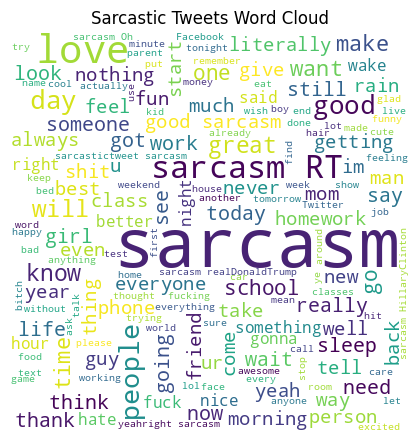

<Figure size 1000x500 with 0 Axes>

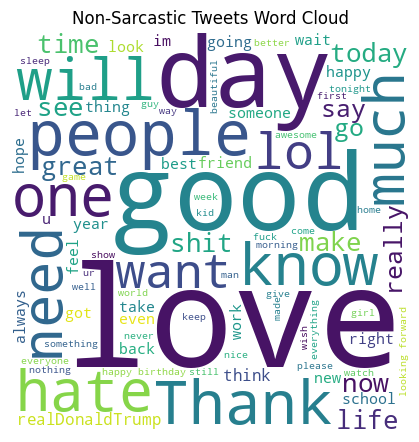

In [8]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
processed_df = pd.read_csv('/content/drive/MyDrive/Labelled_Dataset/LSTM/Dataset2.csv')
# Separate sarcastic and non-sarcastic tweets
sarcastic_tweets = df[df['label'] == 1]['text']
non_sarcastic_tweets = df[df['label'] == 0]['text']

# Function to generate word cloud
def generate_word_cloud(tweets, title):
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(tweets))
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

# Generate word cloud for sarcastic tweets
generate_word_cloud(sarcastic_tweets, 'Sarcastic Tweets Word Cloud')

# Add some space between the plots
plt.figure(figsize=(10, 5))

# Generate word cloud for non-sarcastic tweets
generate_word_cloud(non_sarcastic_tweets, 'Non-Sarcastic Tweets Word Cloud')

# Split the dataset train-test

In [9]:
processed_df = pd.read_csv('/content/drive/MyDrive/Labelled_Dataset/LSTM/Dataset2.csv')

X = processed_df['text'].values
y = processed_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 25
word_index = tokenizer.word_index

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

X_train_flat = X_train_pad.flatten()
X_test_flat = X_test_pad.flatten()

print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of X_test_pad:", X_test_pad.shape)

Shape of X_train_pad: (40951, 25)
Shape of X_test_pad: (10238, 25)


# Load the GLove model

In [10]:
import os
import numpy as np

file_path = '/content/drive/MyDrive/glove(1).twitter.27B.100d.txt'
embeddings_index = {}

if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors.' % len(embeddings_index))
else:
    print('File not found.')

Found 1193514 word vectors.


# Deep Learning Model

# Embedding Layer

In [11]:
embedding_dim = 100  # Assuming you're using GloVe embeddings with 100 dimensions

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24801


In [12]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# Long-short Term Memory - LSTM

In [13]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           3209500   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3326877 (12.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 3209500 (12.24 MB)
_________________________________________________________________
None


In [14]:
history = model.fit(X_train_pad, y_train, batch_size=64, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/10
640/640 - 59s - loss: 0.6345 - acc: 0.6366 - val_loss: 0.6033 - val_acc: 0.6798 - 59s/epoch - 92ms/step
Epoch 2/10
640/640 - 56s - loss: 0.5821 - acc: 0.6900 - val_loss: 0.5599 - val_acc: 0.7075 - 56s/epoch - 88ms/step
Epoch 3/10
640/640 - 54s - loss: 0.5465 - acc: 0.7175 - val_loss: 0.5594 - val_acc: 0.7177 - 54s/epoch - 85ms/step
Epoch 4/10
640/640 - 57s - loss: 0.5190 - acc: 0.7374 - val_loss: 0.5241 - val_acc: 0.7324 - 57s/epoch - 89ms/step
Epoch 5/10
640/640 - 57s - loss: 0.5006 - acc: 0.7491 - val_loss: 0.5228 - val_acc: 0.7360 - 57s/epoch - 89ms/step
Epoch 6/10
640/640 - 55s - loss: 0.4819 - acc: 0.7634 - val_loss: 0.5068 - val_acc: 0.7477 - 55s/epoch - 87ms/step
Epoch 7/10
640/640 - 56s - loss: 0.4679 - acc: 0.7746 - val_loss: 0.5327 - val_acc: 0.7389 - 56s/epoch - 87ms/step
Epoch 8/10
640/640 - 57s - loss: 0.4532 - acc: 0.7807 - val_loss: 0.5047 - val_acc: 0.7520 - 57s/epoch - 90ms/step
Epoch 9/10
640/640 - 55s - loss: 0.4403 - acc: 0.7884 - val_loss: 0.4955 - val_a

# Visualization

**Accuracy and Loss**

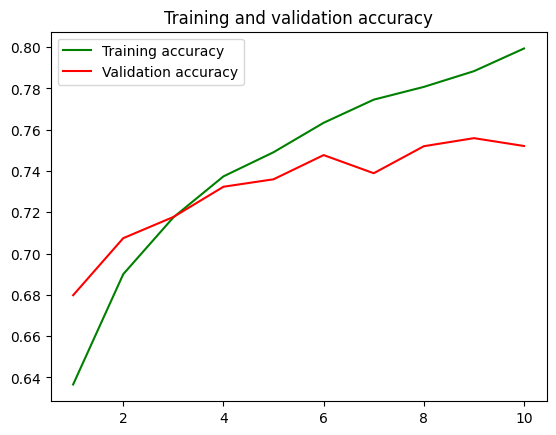

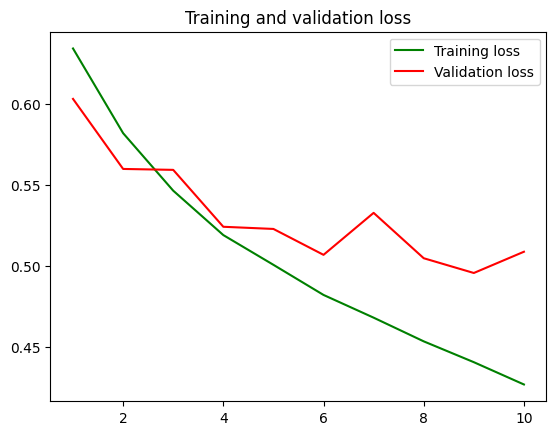

In [15]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Confusion Matrix**

320/320 [==============================] - 6s 16ms/step


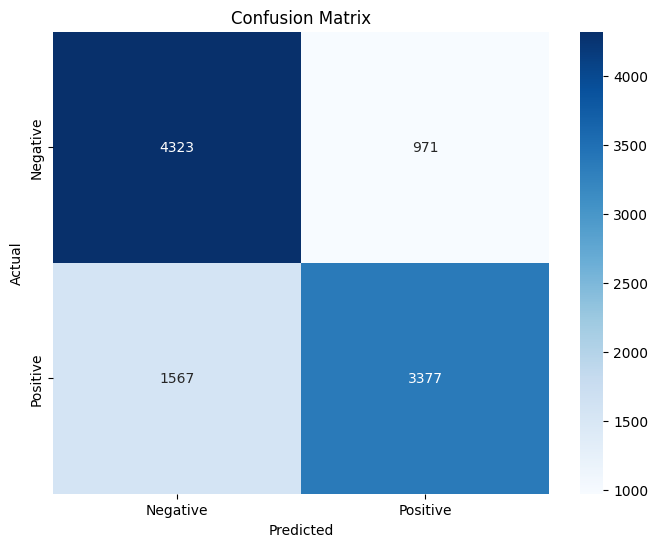

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming model is your trained LSTM model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Assuming y_test is your actual ground truth labels for the entire test set
# Replace this with your actual ground truth labels
y_true = y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix to a 2x2 matrix
cm_reshape = cm.reshape((2, 2))

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reshape, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**F1 Score**

In [17]:
from sklearn.metrics import f1_score

# Assuming model is your trained LSTM model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Assuming y_test is your actual ground truth labels for the entire test set
# Replace this with your actual ground truth labels
y_true = y_test

# Calculate F1-score
f1score = f1_score(y_true, y_pred)

print("F1-score:", f1score)

320/320 [==============================] - 4s 11ms/step
F1-score: 0.7268618166164442


# Prediction

In [29]:
def predict_sarcasm(statement):
    # Clean and tokenize text
    processed_statement = tweet_analyzer.preprocess_tweet(statement)
    test_tokens = [word for word, _ in processed_statement['pos_tags']]

    # Join tokens into a string
    test_text = ' '.join(test_tokens)

    # Replace emojis with descriptions
    test_text = emoji.demojize(test_text)

    # Tokenize and pad for model input
    test_sequence = tokenizer.texts_to_sequences([test_text])
    test_pad = pad_sequences(test_sequence, maxlen=max_length, padding='post')

    # Make prediction
    prediction = model.predict(test_pad)

    # Probability of sarcasm
    sarcasm_probability = prediction[0][0]

    # Check sarcasm threshold
    if sarcasm_probability >= 0.5:
        return "Sarcastic"
    else:
        return "Not Sarcastic"

# Sarcastic Tweets

Only text

In [30]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "My phone just died right before an important call. Fantastic timing!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 57ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 84ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 186ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 99ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 64ms/step
Prediction 5: Sarcastic


Text with emoji

In [31]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "My phone just died right before an important call. Fantastic timing! 📱😫"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing! ⏰💰"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due. 😃🖨️"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet. 🚿🛠️"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 74ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 97ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 37ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 39ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 40ms/step
Prediction 5: Sarcastic


Text with emoji and hashtags

In [32]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄 #Blessed #BestDayEver"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "My phone just died right before an important call. Fantastic timing! 📱😫 #TechFail"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing! ⏰💰 #Sarcasm #DreamsComeTrue"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due. 😃🖨️ #PrinterProblems #Fantastic"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet. 🚿🛠️ #WeekendVibes #DIYQueen"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 28ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 26ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 26ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 24ms/step
Prediction 5: Sarcastic


# Non-Sarcastic Tweets

Only text

In [22]:
text_to_predict = "Feeling grateful for the little joys in life."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 22ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 24ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 24ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 23ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 27ms/step
Prediction 5: Not Sarcastic


Text with emoji

In [23]:
text_to_predict = "Feeling grateful for the little joys in life. 😊"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag.🤍"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear.💯"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 29ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 23ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 23ms/step
Prediction 5: Not Sarcastic


Text with emoji and hashtags

In [24]:
text_to_predict = "Feeling grateful for the little joys in life. 😊 #Gratitude #SimpleJoys"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄 #HappyMoments #JoyfulHeart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag.🤍 #Contentment #Satisfaction"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear.💯 #Hardwork #fearless"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃 #GoodMorning #PositiveStart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 24ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 26ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 27ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 5: Not Sarcastic


# Predict Sarcasm

In [37]:
from ipywidgets import widgets, VBox, Layout

# Function for predicting sarcasm
def predict_sarcasm(text):
    # Clean and preprocess text
    text = emoji.demojize(text)

    # Tokenize and pad input text
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_length, padding='post')

    # Make prediction
    prediction = model.predict(text_pad)

    # Interpret prediction
    sarcasm_probability = prediction[0][0]
    label = "Sarcastic" if sarcasm_probability >= 0.5 else "Not Sarcastic"

    return label

# Create input box widget with styling
text_input = widgets.Text(placeholder='Enter your text here...', description='Text:', layout=Layout(width='50%'))

# Create output widget with styling
output_label = widgets.HTML(value='<b>Result:</b>', layout=Layout(margin='20px 0 0 0'))

# Function to update output label
def update_output_label(sender):
    text = text_input.value
    result = predict_sarcasm(text)
    output_label.value = f'<b>Result:</b> <span style="color:{"red" if result == "Sarcastic" else "green"};">{result}</span>'

# Attach function to input box
text_input.observe(update_output_label, names='value')

# Display widgets
VBox([text_input, output_label])